# Wstęp

Autorzy: \\
Aleksandra Czerczak \\
Mateusz Pałczyński

Plik z danymi o nazwie "House prices in Poland" został pobrany ze strony kaggle (https://www.kaggle.com/datasets/dawidcegielski/house-prices-in-poland.com). Dane pochądzą ze stycznia 2021r. Przedstawiają one zestawienie pewnych cech mieszkań w trzech polskich miastach: Warszawie, Krakowie oraz Poznaniu. Poniżej opisane zostało wyjaśnienie znaczenia poszczególnych kolumn:


*   address - pełny adres
*   city - Warszawa (Warsaw), Kraków (Cracow), Poznań (Poznan)
*   floor - numer piętra, na którym znajduje się mieszkanie
*   id - id mieszkania
*   latitude - szerokość geograficzna
*   longitude - długość geograficzna
*   price - cena mieszkania w PLN
*   rooms - liczba pokoi w mieszkaniu
*   sq - liczba metrów kwadratowych
*   year - rok wybudowania budynku/mieszkania


Na wstępie załadujmy i przedstawmy kilka początkowych wierszy danych.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial import Voronoi, voronoi_plot_2d
import scipy.spatial as sp

#pokazuje obrazki nie w osobnym oknie
%matplotlib inline

#instalujemy Pydrive i zaciągamy odpowiednie rzeczy
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
 
#Uwierzytelnienie i utworzenie klienta PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#kopiujemy link z csv
link = 'https://drive.google.com/file/d/1CvNEnbZ8Dnm-n01x-DkjoXYpLSa_MUWz/view?usp=share_link'
 
 
#to wyciąga potrzebne id z linka
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Houses.csv') 
#zmiana dekodowania, bo oczywiście co - oczywiście błąd
data_origin = pd.read_csv('Houses.csv', encoding='ISO-8859-2')
data_origin.head()





   Unnamed: 0                                            address      city  \
0           0           Podgórze Zabłocie Stanisława Klimeckiego    Kraków   
1           1                          Praga-Południe Grochowska  Warszawa   
2           2                            Krowodrza Czarnowiejska    Kraków   
3           3                                           Grunwald    Poznań   
4           4  Ochota Gotowy budynek. Stan deweloperski. Osta...  Warszawa   

   floor       id   latitude  longitude      price  rooms      sq    year  
0    2.0  23918.0  50.049224  19.970379   749000.0    3.0   74.05  2021.0  
1    3.0  17828.0  52.249775  21.106886   240548.0    1.0   24.38  2021.0  
2    2.0  22784.0  50.066964  19.920025   427000.0    2.0   37.00  1970.0  
3    2.0   4315.0  52.404212  16.882542  1290000.0    5.0  166.00  1935.0  
4    1.0  11770.0  52.212225  20.972630   996000.0    5.0  105.00  2020.0  


Zanim przejdziemy do analizowania danych zrobimy kopię, na której będziemy pracować.

In [ ]:
data_origin.head()

,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznań,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [ ]:
data = data_origin.copy()

Nasze dane mają 11 kolumn i ponad 23000 wierszy.

Naszym celem będzie ustalenie, która z cech najmocniej wpływa na cenę mieszkania w poszczególnych miastach.  Wykorzystując nieparametryczne 
metody regresji (las losowy) stworzymy model przewidujący cenę mieszkania za metr kwadratowy na podstawie poszczególnych cech.

# Preprocessing

Na początku przygotujmy dane do analizy, tzn. wyrzućmy kolumny, które nie będą przydatne (id, unnamed:0, address), sprawdźmy czy mamy jakieś braki danych (NA), sprawdźmy jakie mamy typy danych oraz zwizualizujemy lokalizacje mieszkań za pomocą programu *Tableau*.

In [ ]:
del data ['id']
del data ['address']
del data ['Unnamed: 0']
#data = data.rename(columns={'Unnamed: 0':'id'})
data.head()

,city,floor,latitude,longitude,price,rooms,sq,year
0,Kraków,2.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,Warszawa,3.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,Kraków,2.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,Poznań,2.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,Warszawa,1.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [ ]:
nulls = data.isnull().sum().to_frame()
nulls

,0
city,0
floor,0
latitude,0
longitude,0
price,0
rooms,0
sq,0
year,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23764 entries, 0 to 23763
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   city       23764 non-null  object 
 1   floor      23764 non-null  float64
 2   latitude   23764 non-null  float64
 3   longitude  23764 non-null  float64
 4   price      23764 non-null  float64
 5   rooms      23764 non-null  float64
 6   sq         23764 non-null  float64
 7   year       23764 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.5+ MB


Zmieńmy typ danych na integer dla kolumn *floor, rooms, price, year*.

In [ ]:
data.floor=data.floor.astype('int64')
data.rooms=data.rooms.astype('int64')
data.year=data.year.astype('int64')
data.price=data.price.astype('int64')
data.head()

,city,floor,latitude,longitude,price,rooms,sq,year
0,Kraków,2,50.049224,19.970379,749000,3,74.05,2021
1,Warszawa,3,52.249775,21.106886,240548,1,24.38,2021
2,Kraków,2,50.066964,19.920025,427000,2,37.00,1970
3,Poznań,2,52.404212,16.882542,1290000,5,166.00,1935
4,Warszawa,1,52.212225,20.972630,996000,5,105.00,2020


Dodajmy jeszcze kolumnę *price_sq*, która będzie zawierała cenę danego mieszkania w przeliczeniu na m^2 oraz kolumnę przedstawiającą połowę wartości długości geograficznej potrzebną do klastrowania.

In [ ]:
data['price_sq']=data['price']/data['sq']
data['longitude/2']=data['longitude']/2
data.head()

,city,floor,latitude,longitude,price,rooms,sq,year,price_sq,longitude/2
0,Kraków,2,50.049224,19.970379,749000,3,74.05,2021,10114.787306,9.985190
1,Warszawa,3,52.249775,21.106886,240548,1,24.38,2021,9866.611977,10.553443
2,Kraków,2,50.066964,19.920025,427000,2,37.00,1970,11540.540541,9.960012
3,Poznań,2,52.404212,16.882542,1290000,5,166.00,1935,7771.084337,8.441271
4,Warszawa,1,52.212225,20.972630,996000,5,105.00,2020,9485.714286,10.486315


Na sam początek zobaczmy nasze dane na mapie. W ten sposób będziemy mogli zweryfikować, czy w naszych danych nie ma jakiegoś błędu w kontekście lokalizacji. W tym celu przenieśmy się chwilowo do programu *Tableau*.

Widać, że kilka mieszkań ma błędne długości lub szerokości geograficzne. Dla zwiększenia jakości danych, usuniemy rekordy, które są zlokalizowane poza granicami Polski (odrzucamy też od razu dane z okolic Trójmiasta).

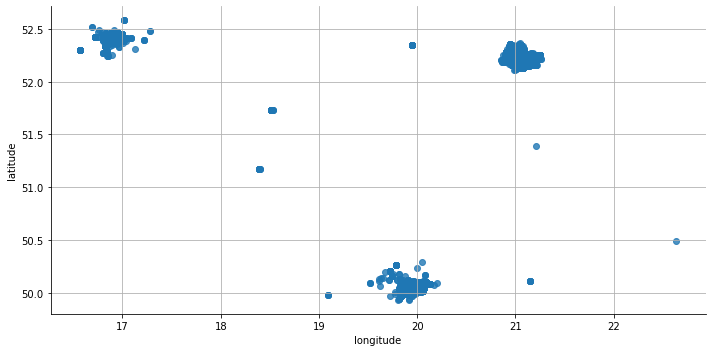

In [ ]:
data.drop(data[data["latitude"]<49].index, inplace=True)
data.drop(data[data["latitude"]>54].index, inplace=True)
data.drop(data[data["longitude"]<14].index, inplace=True)
data.drop(data[data["longitude"]>24].index, inplace=True)
sns.lmplot(x='longitude', y='latitude', data=data, fit_reg=False, height=5, aspect=2)
set_ylim=(49,55)
plt.grid()

Sprawdźmy teraz czy dla kolumn *year, price, sq* mamy jakieś wartości odstające, które mogą być błędnymi danymi. Sprawdzimy to za pomocą wykresu oraz funkcji *describe*.


*   dla *sq*, tzn. powierzchni:

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


count      23738.00
mean         102.77
std         6537.27
min            8.80
25%           42.00
50%           53.89
75%           68.91
max      1007185.00
Name: sq, dtype: float64

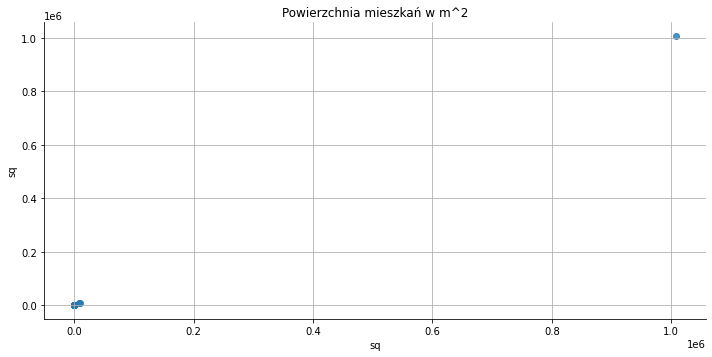

In [ ]:
sns.lmplot(x='sq', y='sq', data=data, fit_reg=False, size=5, aspect=2)
plt.grid()
plt.title('Powierzchnia mieszkań w m^2')
data["sq"].describe().round(2)


Widać, że w naszym zbiorze jest mieszkanie o powierzchni ponad 1 mln $m^2$, co jest niemożliwe. Ponieważ największe mieszkania w Polsce mają ok. 5000 $m^2$ usuwamy dane, które przekraczają ten próg.

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


count    23735.00
mean        59.63
std         28.40
min          8.80
25%         42.00
50%         53.89
75%         68.90
max        442.20
Name: sq, dtype: float64

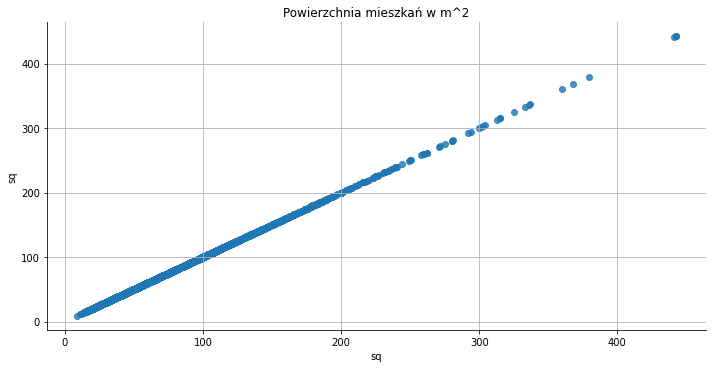

In [ ]:
data.drop(data[data['sq'] > 5000].index, inplace=True)
sns.lmplot(x='sq', y='sq', data=data, fit_reg=False, size=5, aspect=2)
plt.grid()
plt.title('Powierzchnia mieszkań w m^2')
data["sq"].describe().round(2)

*   dla *price*:

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


count       23735.00
mean       649445.56
std        532980.58
min          5000.00
25%        411147.00
50%        520000.00
75%        699999.00
max      15000000.00
Name: price, dtype: float64

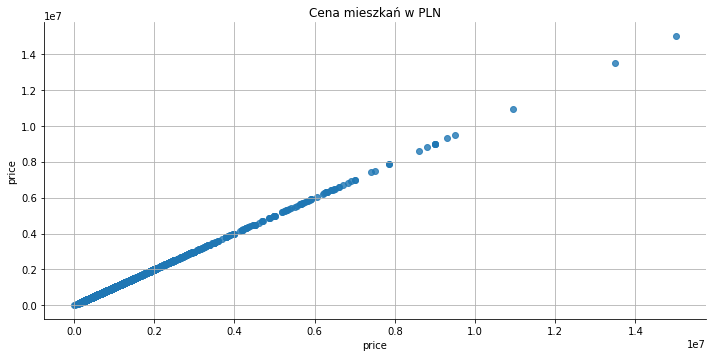

In [ ]:
sns.lmplot(x='price', y='price', data=data, fit_reg=False, size=5, aspect=2)
plt.grid()
plt.title('Cena mieszkań w PLN')
data["price"].describe().round(2)

Najwyższą ceną jest 15.000.000zł, co jest dużą, ale możliwą ceną (np. dla Warszawskich apartamentów), dlatego nie usuwamy tutaj żadnych danych.

*   dla *year*:

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


count    23735.00
mean      2000.58
std         48.32
min         70.00
25%       1985.00
50%       2019.00
75%       2021.00
max       2980.00
Name: year, dtype: float64

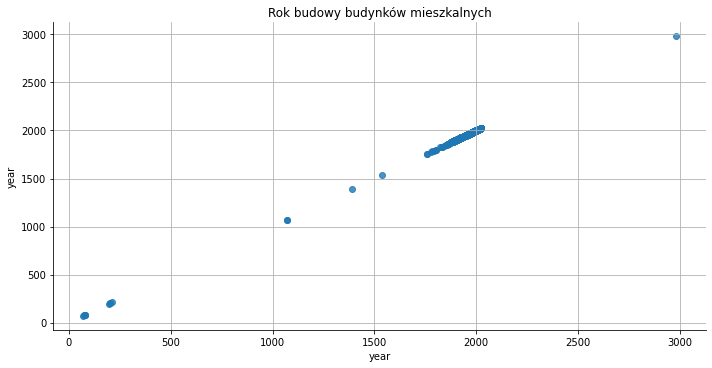

In [ ]:
sns.lmplot(x='year', y='year', data=data, fit_reg=False, size=5, aspect=2)
plt.grid()
plt.title('Rok budowy budynków mieszkalnych')
data["year"].describe().round(2)

Widać, że mamy tu do czynienia z obserwacjami odstającymi (zarówno zbyt małymi jak i ze zbyt dużymi). Ze względu na to, że najstarszy budynek w Polsce pochodzi mniej więcej z roku 1100, decydujemy się usunąć dane spoza zakresu lat 1100-2022.


/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


count    23626.00
mean      2001.23
std         29.99
min       1390.00
25%       1985.00
50%       2019.00
75%       2021.00
max       2022.00
Name: year, dtype: float64

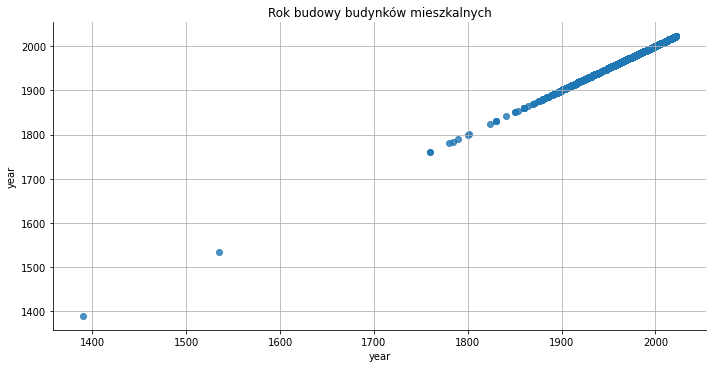

In [ ]:
data.drop(data[((data["year"])<1100) | ((data["year"])>2022)].index, inplace=True)
sns.lmplot(x='year', y='year', data=data, fit_reg=False, size=5, aspect=2)
plt.grid()
plt.title('Rok budowy budynków mieszkalnych')
data["year"].describe().round(2)

Na sam koniec usuniemy kolumnę *price*, gdyż nasza analiza oparta będzie na cenie za metr kwadratowy. 

In [ ]:
del data ['price']
data.head()

,city,floor,latitude,longitude,rooms,sq,year,price_sq,longitude/2
0,Kraków,2,50.049224,19.970379,3,74.05,2021,10114.787306,9.985190
1,Warszawa,3,52.249775,21.106886,1,24.38,2021,9866.611977,10.553443
2,Kraków,2,50.066964,19.920025,2,37.00,1970,11540.540541,9.960012
3,Poznań,2,52.404212,16.882542,5,166.00,1935,7771.084337,8.441271
4,Warszawa,1,52.212225,20.972630,5,105.00,2020,9485.714286,10.486315


# Analiza

Zanim przejdziemy do właściwej analizy danych, podzielmy nasz zbiór na 3 miasta, gdyż naszą analizę będziemy przeprowadzać dla każdego miasta z osobna ze względu na różnice cen, potrzeb oraz charakterystyki rynku w różnych rejonach.

Rysujemy, tym razem w pythonie, lokalizacje mieszkań.

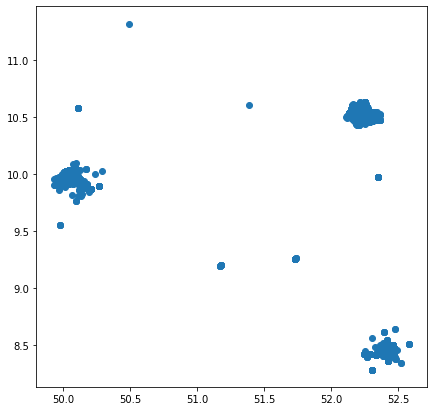

In [ ]:
import warnings
warnings.filterwarnings("ignore")

f , ax = plt.subplots(figsize=(7,7))
plt.scatter(data["latitude"], data["longitude/2"])

Tworzymy model z użyciem algorytmu $KMeans$ dla k=3. 

In [ ]:
km = KMeans(n_clusters = 3)
y_predicted = km.fit_predict(data[["latitude", "longitude/2"]])

Tworzymy kolumnę z przydzielonymi klastrami.

In [ ]:
data["cluster"] = y_predicted
data.head()

,city,floor,latitude,longitude,rooms,sq,year,price_sq,longitude/2,cluster
0,Kraków,2,50.049224,19.970379,3,74.05,2021,10114.787306,9.985190,0
1,Warszawa,3,52.249775,21.106886,1,24.38,2021,9866.611977,10.553443,1
2,Kraków,2,50.066964,19.920025,2,37.00,1970,11540.540541,9.960012,0
3,Poznań,2,52.404212,16.882542,5,166.00,1935,7771.084337,8.441271,2
4,Warszawa,1,52.212225,20.972630,5,105.00,2020,9485.714286,10.486315,1


Rysujemy pogrupowane dane wraz z podziałem pól przydzielonych klastrów.

Text(0, 0.5, 'longitude')

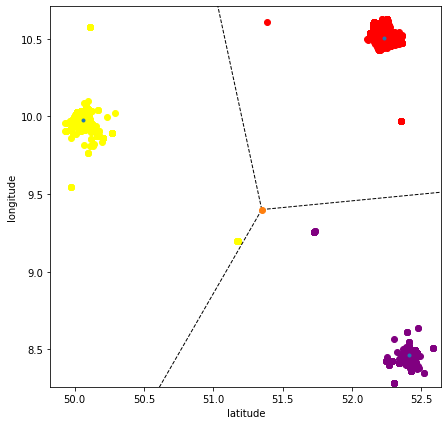

In [ ]:
vor = Voronoi(km.cluster_centers_)
f , ax = plt.subplots(figsize=(7,7))

data1 = data[data.cluster == 0]
data2 = data[data.cluster == 1]
data3 = data[data.cluster == 2]

ax.scatter(data1.latitude, data1["longitude/2"], color = "yellow")
ax.scatter(data2.latitude, data2["longitude/2"], color = "red")
ax.scatter(data3.latitude, data3["longitude/2"], color = "purple")

ax.set_xlim(6.5,12)
ax.set_ylim(49,53)

sp.voronoi_plot_2d(vor, ax=ax)

plt.xlabel("latitude")
plt.ylabel("longitude")

Zauważmy, że mamy kilka punktów na granicy przydzielenia do innych klastrów. Powtarzamy więc procedurę dla k=4.

In [ ]:
km = KMeans(n_clusters = 4)
y_predicted = km.fit_predict(data[["latitude", "longitude/2"]])
data["cluster"] = y_predicted

Text(0, 0.5, 'longitude/2')

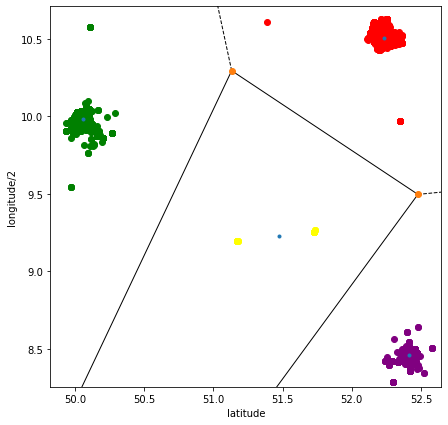

In [ ]:
vor = Voronoi(km.cluster_centers_)
f , ax = plt.subplots(figsize=(7,7))

data1 = data[data.cluster == 0]
data2 = data[data.cluster == 1]
data3 = data[data.cluster == 2]
data4 = data[data.cluster == 3]

ax.scatter(data1.latitude, data1["longitude/2"], color = "yellow")
ax.scatter(data2.latitude, data2["longitude/2"], color = "red")
ax.scatter(data3.latitude, data3["longitude/2"], color = "purple")
ax.scatter(data4.latitude, data4["longitude/2"], color = "green")

ax.set_xlim(6.5,12)
ax.set_ylim(49,53)

sp.voronoi_plot_2d(vor, ax=ax)

plt.xlabel("latitude")
plt.ylabel("longitude/2")

Algorytm doskonale wychwycił kłopotliwe dla nas punkty. Mamy więc ostateczny podział naszych miast, które definiujemy i pobieramy by użyć je w $Tableau$.

In [ ]:
Kra = data[data.cluster == 0]
Poz = data[data.cluster == 1]
War = data[data.cluster == 2]
War.to_csv(r'War.csv', encoding='utf-8')
Kra.to_csv(r'Kra.csv', encoding='utf-8')
Poz.to_csv(r'Poz.csv', encoding='utf-8')
""" Pobranie plików
files.download('War.csv')
files.download('Kra.csv')
files.download('Poz.csv')
"""

" Pobranie plików\nfiles.download('War.csv')\nfiles.download('Kra.csv')\nfiles.download('Poz.csv')\n"

Przejdziemy znów do naszej wizualizacji w $Tableau$

Okazało się, że nadal mamy wartości odstające. Z pomocą przyszedł nam jednak kolejny algorym grupowania: DBSCAN.

In [ ]:
db = DBSCAN(eps=0.2, min_samples=50).fit(data[["latitude", "longitude/2"]])
cluster = db.labels_

In [ ]:
y_predicted = db.fit_predict(data[["latitude", "longitude/2"]])
y_predicted
len(set(cluster))

4

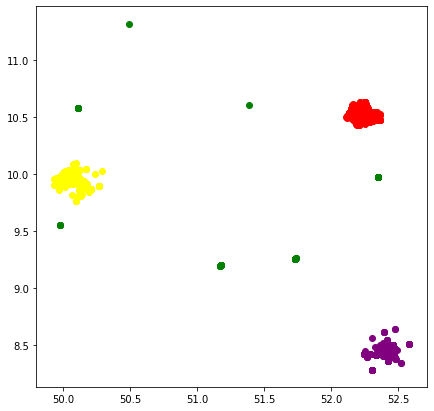

In [ ]:
data["cluster"] = y_predicted
f , ax = plt.subplots(figsize=(7,7))

data1 = data[data.cluster == 0]
data2 = data[data.cluster == 1]
data3 = data[data.cluster == 2]
data4 = data[data.cluster == -1]

ax.scatter(data1.latitude, data1["longitude/2"], color = "yellow")
ax.scatter(data2.latitude, data2["longitude/2"], color = "red")
ax.scatter(data3.latitude, data3["longitude/2"], color = "purple")
ax.scatter(data4.latitude, data4["longitude/2"], color = "green")

Teraz możemy przejść do mapy cieplnej w $Tableau$ przedstawiającej jak wygląda rozkład cen\m^2 w Polsce i w poszczególnych miastach z osobna.

In [ ]:
data["cluster"] = y_predicted
Kra = data[data.cluster == 0]
Poz = data[data.cluster == 1]
War = data[data.cluster == 2]
War.to_csv(r'War2.csv', encoding='utf-8')
Kra.to_csv(r'Kra2.csv', encoding='utf-8')
Poz.to_csv(r'Poz2.csv', encoding='utf-8')
""" Pobieranie
files.download('War2.csv')
files.download('Kra2.csv')
files.download('Poz2.csv')
"""

" Pobieranie\nfiles.download('War2.csv')\nfiles.download('Kra2.csv')\nfiles.download('Poz2.csv')\n"

Zaobserwowaliśmy, że dane w kolumnie *city* nie zawsze pokrywają się z szerokością i długością geograficzną przypisaną do poszczególnych rekorów. W takim wypadku należy zwrócić się do administratora bazy danych. Jednak my nie mamy takich możliwości, dlatego przyjęliśmy, że będziemy się kierować szerokością i długością geograficzną. Z tego powodu kolumna *city* nie będzie nam już potrzebna, dlatego ją usuwamy.

In [ ]:
del Kra ['city']
del War ['city']
del Poz ['city']
Kra.head()
War.head()
Poz.head()

,floor,latitude,longitude,rooms,sq,year,price_sq,longitude/2,cluster
1,3,52.249775,21.106886,1,24.38,2021,9866.611977,10.553443,1
4,1,52.212225,20.972630,5,105.00,2020,9485.714286,10.486315,1
7,10,52.184058,21.044302,6,280.00,2003,10321.428571,10.522151,1
8,3,52.140282,21.056345,4,63.40,1982,9700.315457,10.528173,1
9,1,52.238974,20.913288,1,40.00,1999,10725.000000,10.456644,1


Na nowo nadamy indeksy dla danych z każdego z miast osobno.

In [ ]:
Kra.index=range(1,Kra.shape[0]+1)
War.index=range(1,War.shape[0]+1)
Poz.index=range(1,Poz.shape[0]+1)
Poz.head()

,floor,latitude,longitude,rooms,sq,year,price_sq,longitude/2,cluster
1,3,52.249775,21.106886,1,24.38,2021,9866.611977,10.553443,1
2,1,52.212225,20.972630,5,105.00,2020,9485.714286,10.486315,1
3,10,52.184058,21.044302,6,280.00,2003,10321.428571,10.522151,1
4,3,52.140282,21.056345,4,63.40,1982,9700.315457,10.528173,1
5,1,52.238974,20.913288,1,40.00,1999,10725.000000,10.456644,1


W dalszej analizie skupimy się na określeniu co ma największy wpływ na cenę mieszkania oraz na stworzeniu modelu predykcyjnego cen mieszkań. Zatem naszą kolumną wynikową jest "price/sq". Na samym początku wskażemy zmienną wynikową y i zmienne zależne - X oraz podzielmy nasze dane na zbiór uczący i zbiór testowy. 

In [ ]:
Kra_y = Kra.price_sq
Kra_X = Kra.drop(columns=['price_sq','longitude/2','cluster'])
Poz_y = Poz.price_sq
Poz_X = Poz.drop(columns=['price_sq','longitude/2','cluster'])
War_y = War.price_sq
War_X = War.drop(columns=['price_sq','longitude/2','cluster'])

Kra_X['random'] = np.random.random(size = len(Kra_X))
War_X['random'] = np.random.random(size = len(War_X))
Poz_X['random'] = np.random.random(size = len(Poz_X))


from sklearn.model_selection import train_test_split
Kra_X_train, Kra_X_test, Kra_y_train, Kra_y_test = train_test_split(Kra_X, Kra_y, test_size=0.2)
Poz_X_train, Poz_X_test, Poz_y_train, Poz_y_test = train_test_split(Poz_X, Poz_y, test_size=0.2)
War_X_train, War_X_test, War_y_train, War_y_test = train_test_split(War_X, War_y, test_size=0.2)

Pierwszym podejściem jakie zastosujemy do naszej analizy będzie oparte na intuicyjnym myśleniu dotyczącym wyceny mieszkania. To znaczy dokonamy predykcji mieszkania za pomocą algorytmu $k$-Najbliższych Sąsiadów, który korzysta tylko z cech "latitude" i "longitude". Z tego powodu ze zbiorów testowych i uczących wybierzemy tylko te dwie cechy.

In [ ]:
#from sklearn.model_selection import train_test_split
KraNNX = Kra[["latitude", "longitude"]]
KraNNy = Kra.price_sq
KraNNX_train=Kra_X_train[["latitude", "longitude"]]
KraNNX_test=Kra_X_test[["latitude", "longitude"]]
KraNNy_train=Kra_y_train
KraNNy_test = Kra_y_test

WarNNX = War[["latitude", "longitude"]]
WarNNy = War.price_sq
WarNNX_train=War_X_train[["latitude", "longitude"]]
WarNNX_test=War_X_test[["latitude", "longitude"]]
WarNNy_train=War_y_train
WarNNy_test = War_y_test

PozNNX = Poz[["latitude", "longitude"]]
PozNNy = Poz.price_sq
PozNNX_train=Poz_X_train[["latitude", "longitude"]]
PozNNX_test=Poz_X_test[["latitude", "longitude"]]
PozNNy_train=Poz_y_train
PozNNy_test = Poz_y_test

Ocena modelu kNN i wybranie najlepszego K

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

arr = []
for i in range(1,51):
  clfnK = KNeighborsRegressor(i)
  clfnK.fit(KraNNX_train.values, KraNNy_train.values)

  yKra_pred = clfnK.predict(KraNNX_test.values)
  KnErr = mean_squared_error(KraNNy_test, yKra_pred)
  arr.append(KnErr)
n_parK= [min(arr), arr.index(min(arr))]
print("Min_sq_err: ",min(arr),"Index: ",arr.index(min(arr)))

Min_sq_err:  4186963.584540836 Index:  3


In [ ]:
arr = []
for i in range(1,51):
  clfnW = KNeighborsRegressor(i)
  clfnW.fit(WarNNX_train.values, WarNNy_train.values)

  yWar_pred = clfnW.predict(WarNNX_test.values)
  WnErr = mean_squared_error(WarNNy_test, yWar_pred)
  arr.append(WnErr) 
n_parW= [min(arr), arr.index(min(arr))]
print("Min_sq_err: ",min(arr),"Index: ",arr.index(min(arr)))

Min_sq_err:  1757743.8559861665 Index:  41


In [ ]:
arr = []
for i in range(1,51):
  clfnP = KNeighborsRegressor(i)
  clfnP.fit(PozNNX_train.values, PozNNy_train.values)

  yPoz_pred = clfnP.predict(PozNNX_test.values)
  PnErr = mean_squared_error(PozNNy_test, yPoz_pred)
  arr.append(PnErr) 
n_parP= [min(arr), arr.index(min(arr))]
print("Min_sq_err: ",min(arr),"Index: ",arr.index(min(arr)))

Min_sq_err:  8575175.71108309 Index:  4


Ocena modelu rNN i wybranie najlepszego promienia

In [ ]:
from sklearn.neighbors import RadiusNeighborsRegressor

arr = []
for i in range(1,11):
  clfrK = RadiusNeighborsRegressor(i/10)
  clfrK.fit(KraNNX_train.values, KraNNy_train.values)

  yKra_pred = clfrK.predict(KraNNX_test.values)
  KrErr = mean_squared_error(KraNNy_test, yKra_pred)
  arr.append(KrErr) 
r_parK= [min(arr), (arr.index(min(arr))+1)/10]
print("Min_sq_err: ",min(arr),"Index: ",(arr.index(min(arr))+1)/10)

Min_sq_err:  9804478.279638711 Index:  0.1


In [ ]:
arr = []
for i in range(1,11):
  clfrW = RadiusNeighborsRegressor(i/8) #dzielimy przez największą liczbę którą przyjmuje program
  clfrW.fit(WarNNX_train.values, WarNNy_train.values)

  yWar_pred = clfrW.predict(WarNNX_test.values)
  WrErr = mean_squared_error(WarNNy_test, yWar_pred)
  arr.append(WrErr) 
r_parW= [min(arr), (arr.index(min(arr))+1)/8]
print("Min_sq_err: ",min(arr),"Index: ",(arr.index(min(arr))+1)/8)

Min_sq_err:  2178976.2235195185 Index:  0.375


In [ ]:
arr = []
for i in range(1,11):
  clfrP = RadiusNeighborsRegressor(i/10)
  clfrP.fit(PozNNX_train.values, PozNNy_train.values)

  yPoz_pred = clfrP.predict(PozNNX_test.values)
  PrErr = mean_squared_error(PozNNy_test, yPoz_pred)
  arr.append(PrErr) #Poznań radius error
r_parP= [min(arr), (arr.index(min(arr))+1)/10]
print("Min_sq_err: ",min(arr),"Index: ",(arr.index(min(arr))+1)/10)

Min_sq_err:  17364072.640507873 Index:  0.1


Porównanie kNN vs rNN i wybór najlepszych modeli.

In [ ]:
print(r_parK, n_parK,'\n',r_parW, n_parW,'\n', r_parP, n_parP)

[9804478.279638711, 0.1] [4186963.584540836, 3] 
 [2178976.2235195185, 0.375] [1757743.8559861665, 41] 
 [17364072.640507873, 0.1] [8575175.71108309, 4]


Zauważmy, że wersja algorymu *Najbliższych Sąsiadów* wykorzystująca $k$ jest lepsza niż ta z promieniem w każdym przypadku.
Ostatecznie najlepsze modele $kNN$ dla odpowiednich miast mają następującą formę: 

In [ ]:
clfnK = KNeighborsRegressor(n_parK[1])
clfnK.fit(KraNNX_train.values, KraNNy_train.values)

clfnW = KNeighborsRegressor(n_parW[1])
clfnW.fit(WarNNX_train.values, WarNNy_train.values)

clfnP = KNeighborsRegressor(n_parP[1])
clfnP.fit(PozNNX_train.values, PozNNy_train.values)

KNeighborsRegressor(n_neighbors=4)

Kolejnym zastosową przez nas metodą będzie użycie modelu predykcyjnego cen mieszkań z użyciem metody $Random forest$

Zaczniemy od zdefiniowania Random Forest z domyślnymi parametrami dla poszczególnych miast.

In [ ]:


from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor()
rf1.fit(Kra_X_train.values,Kra_y_train.values)

rf1.score(Kra_X_test, Kra_y_test)


0.7400566766412627

In [ ]:
rf2 = RandomForestRegressor()
rf2.fit(War_X_train.values,War_y_train.values)

rf2.score(War_X_test, War_y_test)

0.5947248274078122

In [ ]:
rf3 = RandomForestRegressor()
rf3.fit(Poz_X_train.values,Poz_y_train.values)

rf3.score(Poz_X_test, Poz_y_test)

0.7306790975315296

Dalej poszukamy optymalnych parametrów.

Text(0.5, 1.0, 'Błąd modelu w zależności od wielkości lasu - Kraków')

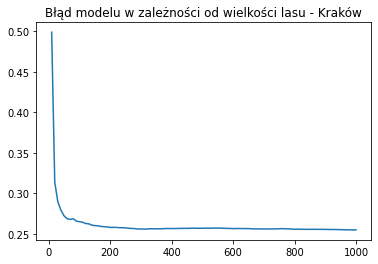

In [ ]:
import time 
error_rate = []
times = []
min_estimators = 10
max_estimators = 1000

rfk = RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features=1/3, n_jobs=-1)

for i in range(min_estimators,max_estimators+1, 10):
  rfk.set_params(n_estimators=i)
  start_time = time.time()
  rfk.fit(Kra_X,Kra_y)
  times.append(round(time.time() - start_time, 2))

  oob_error = 1 - rfk.oob_score_
  error_rate.append(oob_error)

x_axis = range(min_estimators,max_estimators+1, 10)

plt.plot(x_axis, error_rate)
plt.title('Błąd modelu w zależności od wielkości lasu - Kraków')

Text(0.5, 1.0, 'Błąd modelu w zależności od wielkości lasu - Warszawa')

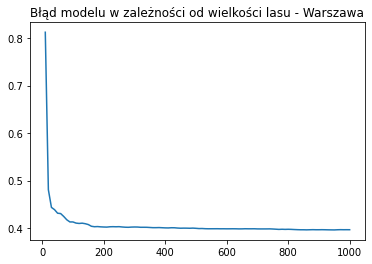

In [ ]:
error_rate = []
times = []
min_estimators = 10
max_estimators = 1000

rfw = RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features=1/3, n_jobs=-1)

for i in range(min_estimators,max_estimators+1, 10):
  rfw.set_params(n_estimators=i)
  start_time = time.time()
  rfw.fit(War_X,War_y)
  times.append(round(time.time() - start_time, 2))

  oob_error = 1 - rfw.oob_score_
  error_rate.append(oob_error)

x_axis = range(min_estimators,max_estimators+1, 10)

plt.plot(x_axis, error_rate)
plt.title('Błąd modelu w zależności od wielkości lasu - Warszawa')

Text(0.5, 1.0, 'Błąd modelu w zależności od wielkości lasu - Poznań')

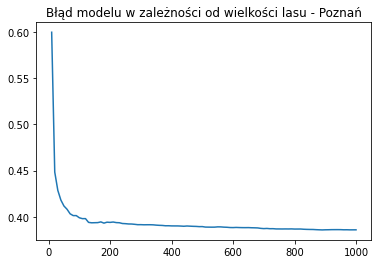

In [ ]:
error_rate = []
times = []
min_estimators = 10
max_estimators = 1000

rfp = RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features=1/3, n_jobs=-1)

for i in range(min_estimators,max_estimators+1, 10):
  rfp.set_params(n_estimators=i)
  start_time = time.time()
  rfp.fit(Poz_X,Poz_y)
  times.append(round(time.time() - start_time, 2))

  oob_error = 1 - rfp.oob_score_
  error_rate.append(oob_error)

x_axis = range(min_estimators,max_estimators+1, 10)

plt.plot(x_axis, error_rate)
plt.title('Błąd modelu w zależności od wielkości lasu - Poznań')

200 drzew losowych wydaje się odpowiednim wyborem dla Krakowa i Warszawy, natomiast dla Poznania optymalnym wyborem wydaje się 150 drzew, ponieważ przy większej ilości drzew nie zwiększają one już efektywności modelu.

Teraz użyjemy losowego przeszukiwania z walidacją krzyżową by znaleźć odpowiednie hiperparametry.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rfk = RandomForestRegressor(n_estimators=200, n_jobs=-1)

param_grid = {'max_depth': [2,3,4,5,6,7,8,None], 
              'min_samples_leaf': range(1,31), 'max_features':range(2,7)
              }
rfk_rscv = RandomizedSearchCV(rfk, param_grid, n_iter=100, cv=5, n_jobs=-1)
rfk_rscv.fit(Kra_X, Kra_y)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8,
                                                      None],
                                        'max_features': range(2, 7),
                                        'min_samples_leaf': range(1, 31)})

In [ ]:
#najlepsze parametry
featK = rfk_rscv.best_params_.get('max_features')
leafK = rfk_rscv.best_params_.get('min_samples_leaf')
rfk_rscv.best_params_

{'min_samples_leaf': 1, 'max_features': 3, 'max_depth': None}

In [ ]:

rfw = RandomForestRegressor(n_estimators=200, n_jobs=-1)

param_grid = {'max_depth': [2,3,4,5,6,7,8,None], 
              'min_samples_leaf': range(1,31), 'max_features':range(2,7)
              }
rfw_rscv = RandomizedSearchCV(rfw, param_grid, n_iter=100, cv=5, n_jobs=-1)
rfw_rscv.fit(War_X, War_y)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8,
                                                      None],
                                        'max_features': range(2, 7),
                                        'min_samples_leaf': range(1, 31)})

In [ ]:
featW = rfw_rscv.best_params_.get('max_features')
leafW = rfw_rscv.best_params_.get('min_samples_leaf')
rfw_rscv.best_params_

{'min_samples_leaf': 1, 'max_features': 2, 'max_depth': None}

In [ ]:
rfp = RandomForestRegressor(n_estimators=150, n_jobs=-1)

param_grid = {'max_depth': [2,3,4,5,6,7,8,None], 
              'min_samples_leaf': range(1,31), 'max_features':range(2,7)
              }
rfp_rscv = RandomizedSearchCV(rfp, param_grid, n_iter=100, cv=5, n_jobs=-1)
rfp_rscv.fit(Poz_X, Poz_y)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_estimators=150, n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8,
                                                      None],
                                        'max_features': range(2, 7),
                                        'min_samples_leaf': range(1, 31)})

In [ ]:
featP = rfp_rscv.best_params_.get('max_features')
leafP = rfp_rscv.best_params_.get('min_samples_leaf')
rfp_rscv.best_params_

{'min_samples_leaf': 8, 'max_features': 6, 'max_depth': None}

Teraz sprawdzimy, która cecha najbardziej wpływa na cenę mieszkań dla każdego z miast z osobna.

Text(0.5, 1.0, 'Wpływ cech na cenę\\m^2 - Kraków')

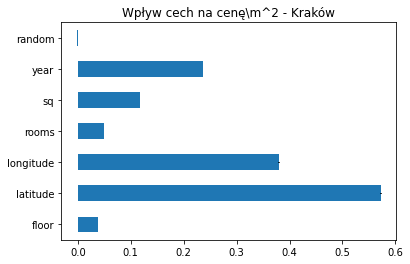

In [ ]:
from sklearn.inspection import permutation_importance

rfk = RandomForestRegressor(n_estimators = 200, max_features=featK, min_samples_leaf=leafK, n_jobs=-1)
rfk.fit(Kra_X_train,Kra_y_train)

result = permutation_importance(
    rfk, Kra_X_test, Kra_y_test, n_repeats=10)

forest_importances = pd.Series(result.importances_mean, index=Kra_X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=result.importances_std, ax=ax)

plt.title('Wpływ cech na cenę\m^2 - Kraków')

Text(0.5, 1.0, 'Wpływ cech na cenę\\m^2 - Warszawa')

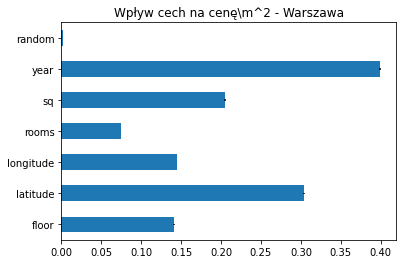

In [ ]:
from sklearn.inspection import permutation_importance

rfw = RandomForestRegressor(n_estimators = 200, max_features=featW, min_samples_leaf=leafW, n_jobs=-1)
rfw.fit(War_X_train,War_y_train)

result = permutation_importance(
    rfw, War_X_test, War_y_test, n_repeats=10)

forest_importances = pd.Series(result.importances_mean, index=War_X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=result.importances_std, ax=ax)

plt.title('Wpływ cech na cenę\m^2 - Warszawa')

Text(0.5, 1.0, 'Wpływ cech na cenę\\m^2 - Poznań')

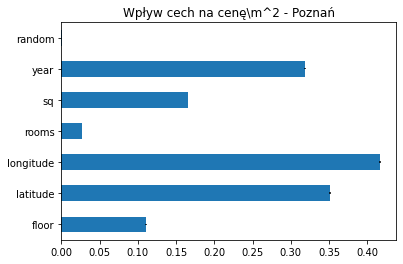

In [ ]:
from sklearn.inspection import permutation_importance

rfp = RandomForestRegressor(n_estimators = 150, max_features=featP, min_samples_leaf=leafP, n_jobs=-1)
rfp.fit(Poz_X_train,Poz_y_train)

result = permutation_importance(
    rfp, Poz_X_test, Poz_y_test, n_repeats=10)

forest_importances = pd.Series(result.importances_mean, index=Poz_X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=result.importances_std, ax=ax)

plt.title('Wpływ cech na cenę\m^2 - Poznań')

Widzimy, że w Krakowie ceny mieszkań zależą głównie od szerokości i długości geograficznej, czyli od dzielnicy.
W Warszawie największy wpływ ma rok budynku, w którym znajduje się mieszkanie, a w następnej kolejności dzielnica.
W Poznaniu cena mieszkań w dużej mierze zależy również od dzielnicy oraz roku budynku.

# Podsumowanie

In [ ]:
rfk = RandomForestRegressor(n_estimators = 200, max_features=featK, min_samples_leaf=leafK, n_jobs=-1, max_depth=16)
rfk.fit(Kra_X_train,Kra_y_train)

rfk.score(Kra_X_test, Kra_y_test)

0.7227626600049386

In [ ]:
rfw = RandomForestRegressor(n_estimators = 200, max_features=featW, min_samples_leaf=leafW, n_jobs=-1)
rfw.fit(War_X_train,War_y_train)

rfw.score(War_X_test, War_y_test)

0.5797209521531282

In [ ]:
rfp = RandomForestRegressor(n_estimators = 150, max_features=featP, min_samples_leaf=leafP, n_jobs=-1)
rfp.fit(Poz_X_train,Poz_y_train)

rfp.score(Poz_X_test, Poz_y_test)

0.6792755495926097

Ostateczne porównanie modeli na losowej próbce oraz podsumowanie.

In [ ]:
KraNNX_test.index=range(1,KraNNX_test.shape[0]+1)
Kra_X_test.index=range(1,Kra_X_test.shape[0]+1)

WarNNX_test.index=range(1,WarNNX_test.shape[0]+1)
War_X_test.index=range(1,War_X_test.shape[0]+1)

PozNNX_test.index=range(1,PozNNX_test.shape[0]+1)
Poz_X_test.index=range(1,Poz_X_test.shape[0]+1)

In [ ]:
n1 = int(0.1*len(Kra_X_test))
n2 = int(0.1*len(War_X_test))
n3 = int(0.1*len(Poz_X_test))

In [ ]:
import random
from statistics import mean

faktyczne = []
wycenaRF = []
blendyRF = []
wycenaNN = []
blendyNN = []
for i in range(n1):
  random.seed(i)
  sample = Kra_X_test.loc[random.randint(1, len(Kra_X_test)),]  # definiujemy dane do przewidzenia
  sample2 = KraNNX_test.loc[random.randint(1, len(KraNNX_test)),]

  Xnew1 = [sample]
  Xnew2 = [sample2]
  real = Kra_y.loc[random.randint(1, len(Kra_X_test)),]
  ynew1 = rfk.predict(Xnew1) # dokonywujemy predykcji
  ynew2 = clfnK.predict(Xnew2)
  faktyczne.append(real)
  wycenaRF.append(ynew1[0])
  blendyRF.append(abs(ynew1[0]-real)/real)
  wycenaNN.append(ynew2[0])
  blendyNN.append(abs(ynew2[0]-real)/real)
print("Faktyczne ceny/metr^2: ",faktyczne[1:5])  #pierwsze kilka pokażemy
print("Wycena RF: ",wycenaRF[1:5]) 
print("Średnia błędów RF: ", mean(blendyRF)) 
print("Wycena NN: ",wycenaNN[1:5]) 
print("Średnia błędów NN: ",mean(blendyNN)) #doliczyć średnią

Faktyczne ceny/metr^2:  [9600.0, 11755.116826661837, 8489.36170212766, 9485.29411764706]
Wycena RF:  [8986.288305859845, 6963.5558655932655, 8793.663045189569, 11550.61302662698]
Średnia błędów RF:  0.30827116414392575
Wycena NN:  [11591.46319696665, 10492.23252160001, 10286.165792906326, 12067.328050329685]
Średnia błędów NN:  0.2995960434715576


In [ ]:
faktyczne = []
wycenaRF = []
blendyRF = []
wycenaNN = []
blendyNN = []
for i in range(n2):
  random.seed(i)
  sample = War_X_test.loc[random.randint(1, len(War_X_test)),]  # definiujemy dane do przewidzenia
  sample2 = WarNNX_test.loc[random.randint(1, len(WarNNX_test)),]

  Xnew1 = [sample]
  Xnew2 = [sample2]
  real = War_y.loc[random.randint(1, len(War_X_test)),]
  ynew1 = rfw.predict(Xnew1) # dokonywujemy predykcji
  ynew2 = clfnW.predict(Xnew2)
  faktyczne.append(real)
  wycenaRF.append(ynew1[0])
  blendyRF.append(abs(ynew1[0]-real)/real)
  wycenaNN.append(ynew2[0])
  blendyNN.append(abs(ynew2[0]-real)/real)
print("Faktyczne ceny/metr^2: ",faktyczne[1:5])  
print("Wycena RF: ",wycenaRF[1:5]) 
print("Średnia błędów RF: ", mean(blendyRF)) 
print("Wycena NN: ",wycenaNN[1:5]) 
print("Średnia błędów NN: ",mean(blendyNN)) 

Faktyczne ceny/metr^2:  [12000.0, 12000.0, 7347.368421052632, 9000.0]
Wycena RF:  [7138.095840892575, 6981.6320218822375, 9564.156934937093, 6443.931762733971]
Średnia błędów RF:  0.1742993286674931
Wycena NN:  [7837.399632341922, 7006.61417234093, 7040.112147013824, 9442.157984950722]
Średnia błędów NN:  0.15901054876464196


In [ ]:
faktyczne = []
wycenaRF = []
blendyRF = []
wycenaNN = []
blendyNN = []
for i in range(n3):
  random.seed(i)
  sample = Poz_X_test.loc[random.randint(1, len(Poz_X_test)),]  # definiujemy dane do przewidzenia
  sample2 = PozNNX_test.loc[random.randint(1, len(PozNNX_test)),]

  Xnew1 = [sample]
  Xnew2 = [sample2]
  real = Poz_y.loc[random.randint(1, len(Poz_X_test)),]
  ynew1 = rfp.predict(Xnew1) # dokonywujemy predykcji
  ynew2 = clfnP.predict(Xnew2)
  faktyczne.append(real)
  wycenaRF.append(ynew1[0])
  blendyRF.append(abs(ynew1[0]-real)/real)
  wycenaNN.append(ynew2[0])
  blendyNN.append(abs(ynew2[0]-real)/real)
# blRF=mean_squared_error(faktyczne, wycenaRF,  squared=True)
#blNN=mean_squared_error(faktyczne, wycenaNN,  squared=True)
print("Faktyczne ceny/metr^2: ",faktyczne[1:5])  
print("Wycena RF: ",wycenaRF[1:5]) 
print("Średnia błędów RF: ", mean(blendyRF)) 
print("Wycena NN: ",wycenaNN[1:5]) 
print("Średnia błędów NN: ",mean(blendyNN)) 
#print("Błąd średnio kw RF: ", blRF)
#print("Błąd średnio kw NN: ", blNN)

Faktyczne ceny/metr^2:  [11111.111111111111, 9863.588667366212, 15893.939393939394, 6121.323529411765]
Wycena RF:  [12724.41693971125, 10590.36636098562, 9389.909975317485, 11442.05624933314]
Średnia błędów RF:  0.3021596260508494
Wycena NN:  [9551.8090342577, 10132.351387288836, 10357.700305974262, 13893.470858629647]
Średnia błędów NN:  0.30902735931867226


Z naszej analizy wynika, że algorytmy mają podobną jakość predykcji. Ponieważ szerekość i długość geograficzna okazały się tak istonymi cechami, algorytm $k$-NN pomimo swojej prostoty okazał się być tak dobry jak algorytm $Random Forest$.

# Bibliografia

Projekt został wykonany na podstawie wykładu z przedmiotu "Stosowane modele analizy danych", a także na podstawie prezentacji prof. Głąba o drzewach i lasach losowych.
Poszczególne kody pochodzą z następujących stron internetowych:
*    http://sigmaquality.pl/uncategorized/zastosowanie-estymatora-random-forest-do-tworzenia-prognozy-zapadalnosc-na-cukrzyce/,
*  http://books.icse.us.edu.pl/runestone/static/ai/IstotaUczeniaNadzorowanegoINienadzorowanego/ReprezentacjaWzorcow.html 